<a href="https://colab.research.google.com/github/kumarmohit0911/AAA/blob/main/Basic_gans_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset, DataLoader

In [21]:
class Descriminator(nn.Module):
  def __init__(self,img_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(img_dim,128),
        nn.LeakyReLU(0.2),
        nn.Linear(128,1),
        nn.Sigmoid()
    )

  def forward(self,x):
    x = self.disc(x)
    return x

In [22]:
class Generator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,img_dim),
        nn.Tanh()
    )
  def forward(self,x):
    x = self.gen(x)
    return x

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)
lr = 3e-4
z_dim = 64
img_dim = 28*28*1
batch_size = 32
epochs = 50

cuda


In [24]:
disc = Descriminator(img_dim).to(device)
gen = Generator(z_dim,img_dim).to(device)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

In [26]:
dataset = datasets.MNIST(root = "dataset/",transform=transform,download= True)

In [27]:
loader = DataLoader(dataset,batch_size=batch_size,shuffle= True)

In [28]:
opt_disc = optim.Adam(disc.parameters(), lr = lr,betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr = lr, betas=(0.5, 0.999) )

In [29]:
Criterion = nn.BCELoss()

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

In [31]:
step = 0

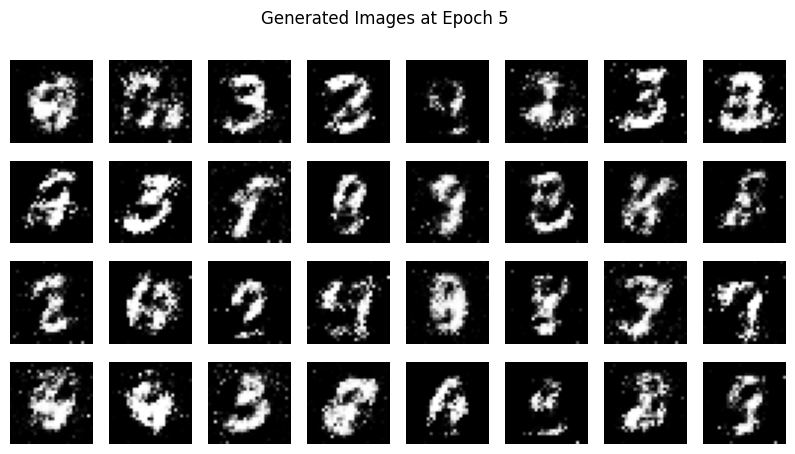

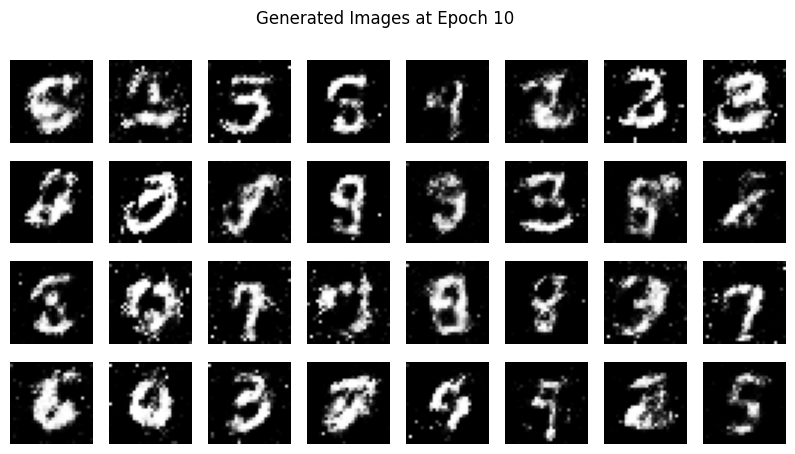

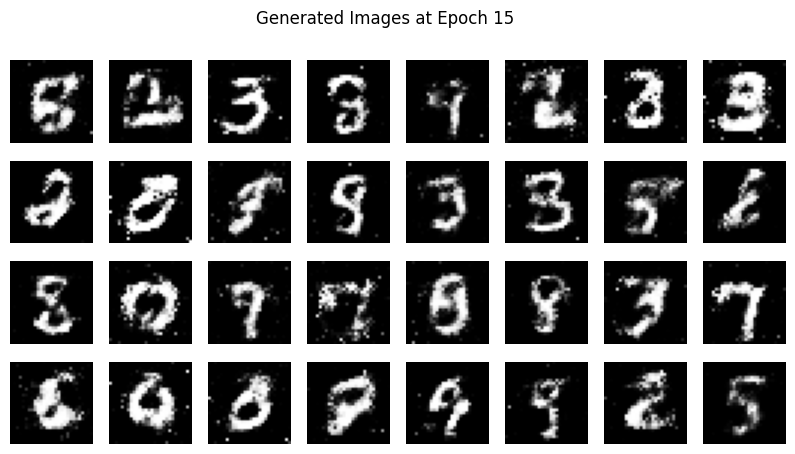

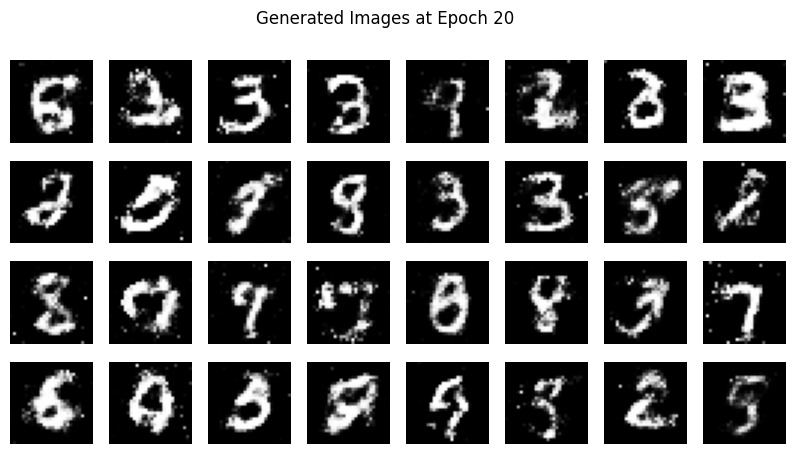

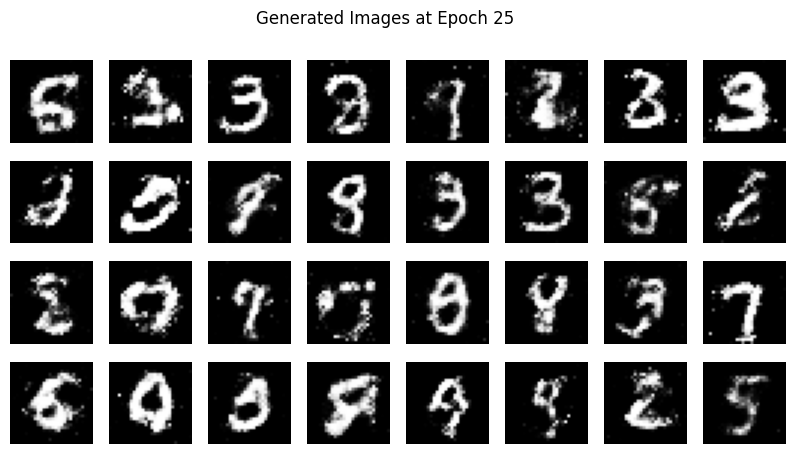

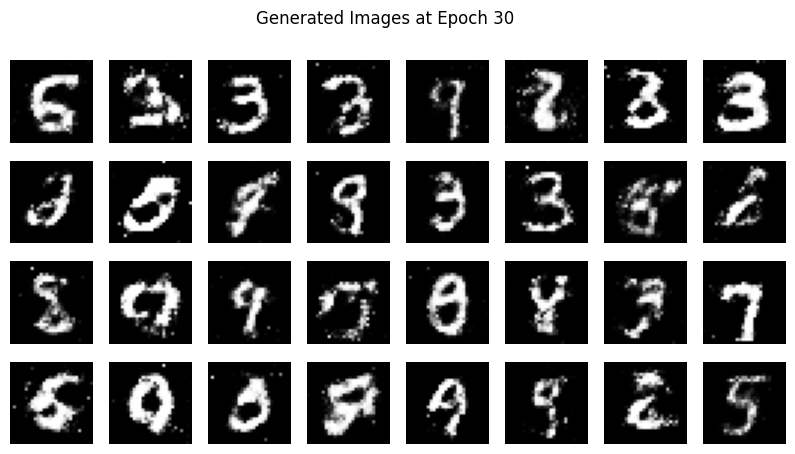

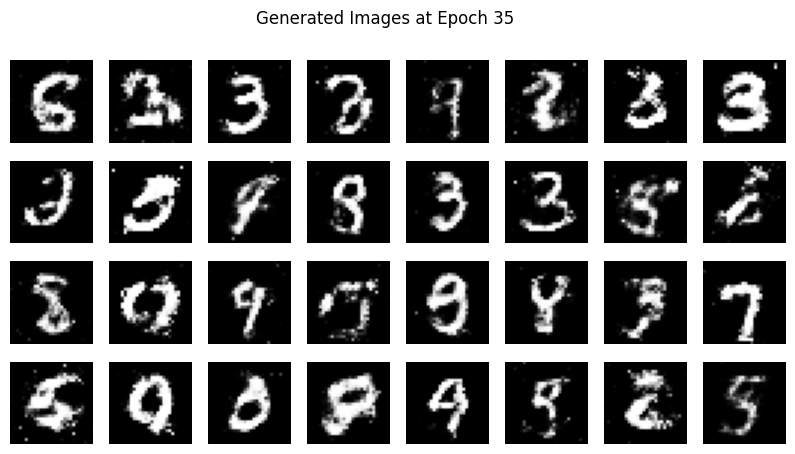

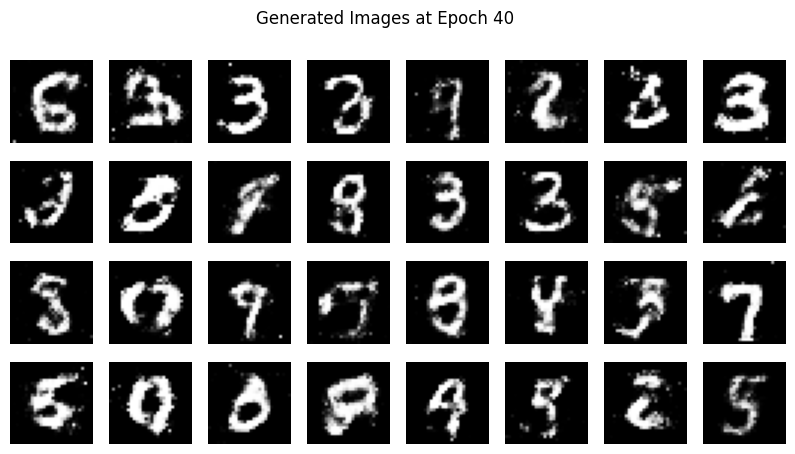

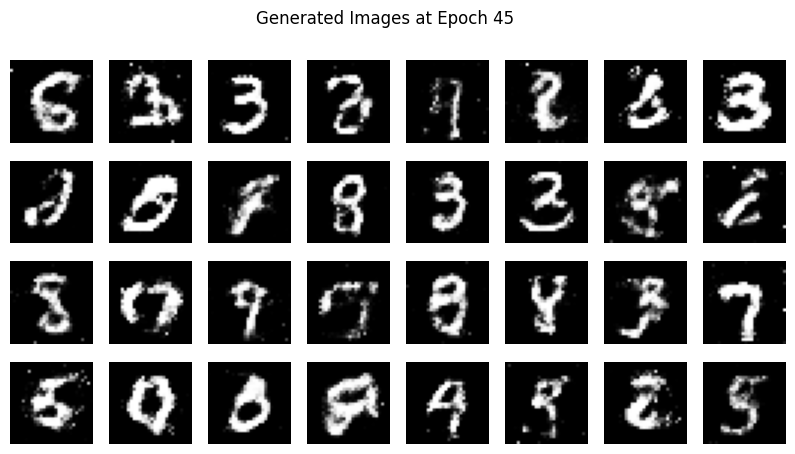

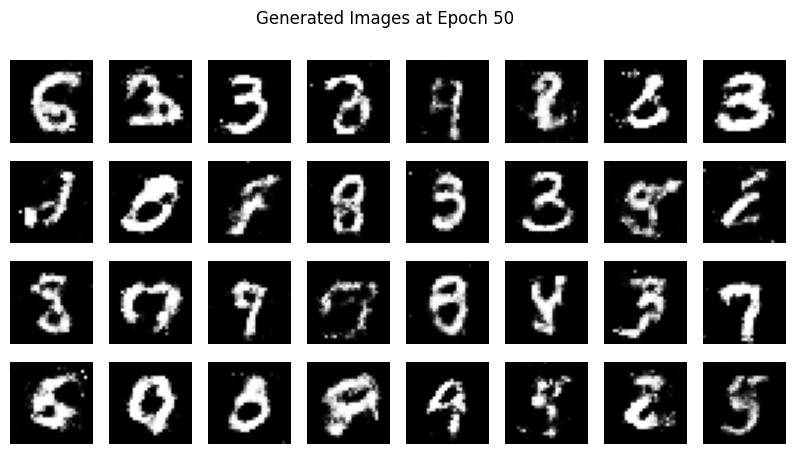

Epoch [50/50] | Loss D: 0.5405 | Loss G: 1.2877


In [34]:
losses_D = []
losses_G = []
for epoch in range(epochs):
  if (epoch + 1) % 5 == 0:
      show_generated_images(gen, fixed_noise, epoch+1)
  lossD_epoch = 0.0
  lossG_epoch = 0.0
  for batch_idx,(real,_) in enumerate(loader):
    real = real.view(-1,784).to(device)
    batch_size = real.shape[0]
    #loss fnxn for discriminator
    # max log(D(G)) + log(1-D(G(Z))) --> Z is the noise
    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise) #fake image generated
    disc_real = disc(real).view(-1) # real image is fed to the descriminator
    lossD_real = Criterion(disc_real,torch.ones_like(disc_real))
    disc_fake = disc(fake.detach()).view(-1)
    lossD_fake = Criterion(disc_fake,torch.zeros_like(disc_fake))
    lossD = (lossD_fake + lossD_real )/2
    disc.zero_grad()
    lossD.backward()
    opt_disc.step()
    # training generator
    # max(log(D(G(Z)))
    output = disc(fake).view(-1)
    lossG = Criterion(output,torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()
    # accumulate losses
    lossD_epoch += lossD.item()
    lossG_epoch += lossG.item()
avg_lossD = lossD_epoch / len(loader)
avg_lossG = lossG_epoch / len(loader)

losses_D.append(avg_lossD)
losses_G.append(avg_lossG)

print(
    f"Epoch [{epoch+1}/{epochs}] | "
    f"Loss D: {avg_lossD:.4f} | "
    f"Loss G: {avg_lossG:.4f}"
)

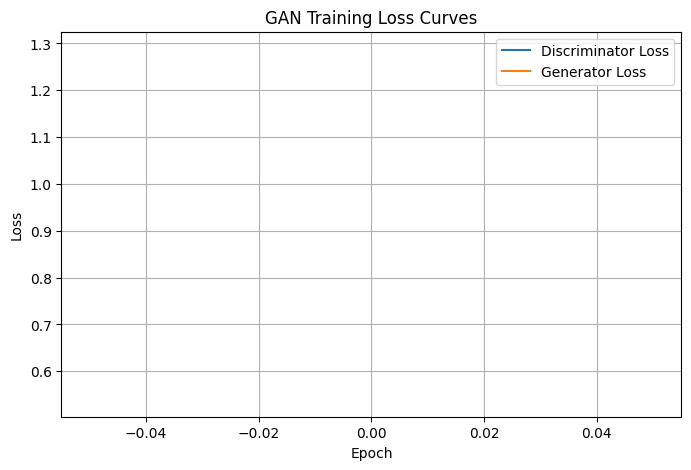

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
def show_generated_images(generator, noise, epoch=None):
    generator.eval()
    with torch.no_grad():
        fake = generator(noise)
        fake = fake.view(-1, 1, 28, 28)

    fake = fake.cpu()

    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake[i][0], cmap="gray")
        ax.axis("off")

    if epoch is not None:
        plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()

    generator.train()
